# 课程实验三：学号识别

- 任务输入：学号照片
- 任务输出：学号数字序列
- 训练集：MNIST（本地已缓存）
- 目标：构建并训练手写数字识别模型，完成学号照片的数字识别与可视化分析。


#### 整体思路与数据准备
训练：使用 MNIST 28×28 训练轻量 CNN。
推理：与 predict_id.py 相同的 OpenCV 流程——灰度+高斯模糊→Otsu 二值/可选反色→形态学闭操作去噪→Canny 行列投影粗裁剪→轮廓外接矩形分割，若轮廓不足则列投影切分连体→裁空白、方形填充、缩放到 28×28→按 MNIST 均值方差归一化→模型逐位预测并可视化。


In [1]:
# 依赖引入与运行环境设置
import os, time, random, math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import cv2

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_root = "data"
print(f"Using device: {device}")

Using device: cuda


#### MNIST 加载与划分策略
使用本地缓存的 MNIST，按 9:1 划分验证集，统一标准化。


In [2]:
# 加载 MNIST 数据集并划分训练/验证/测试集
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

def mnist_needs_download(root):
    processed = os.path.join(root, "MNIST", "processed")
    raw = os.path.join(root, "MNIST", "raw")
    processed_ok = os.path.exists(os.path.join(processed, "training.pt")) and os.path.exists(os.path.join(processed, "test.pt"))
    raw_files = ["train-images-idx3-ubyte", "train-labels-idx1-ubyte", "t10k-images-idx3-ubyte", "t10k-labels-idx1-ubyte"]
    raw_ok = os.path.exists(raw) and all(os.path.exists(os.path.join(raw, f)) or os.path.exists(os.path.join(raw, f + ".gz")) for f in raw_files)
    return not (processed_ok or raw_ok)

need_download = mnist_needs_download(data_root)
print(f"MNIST download needed: {need_download}")

train_full = datasets.MNIST(root=data_root, train=True, transform=transform, download=need_download)
test_ds = datasets.MNIST(root=data_root, train=False, transform=transform, download=need_download)
val_size = 10000
train_size = len(train_full) - val_size
train_ds, val_ds = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(42))

batch_size = 128
loader_kwargs = dict(batch_size=batch_size, num_workers=2, pin_memory=True)
train_loader = DataLoader(train_ds, shuffle=True, **loader_kwargs)
val_loader = DataLoader(val_ds, shuffle=False, **loader_kwargs)
test_loader = DataLoader(test_ds, shuffle=False, **loader_kwargs)

print(f"Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")

MNIST download needed: True


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.60MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 152kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.94MB/s]

Train/Val/Test sizes: 50000/10000/10000


#### 样本可视化与分布检查
查看样本与像素分布，确认灰度范围。


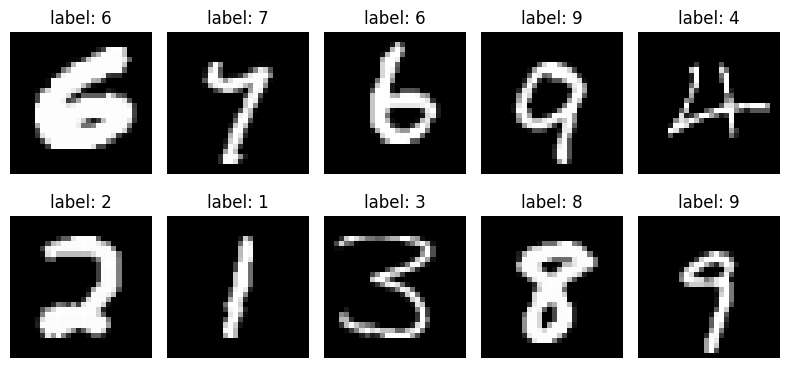

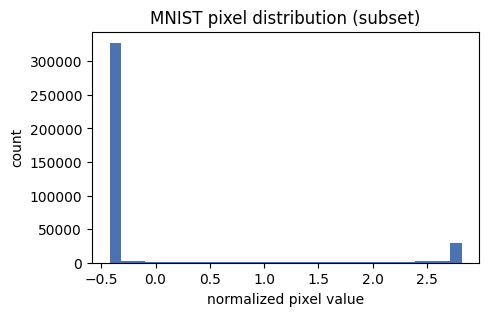

In [3]:
# 可视化样本与像素分布
fig, axes = plt.subplots(2, 5, figsize=(8, 4))
for ax, idx in zip(axes.flat, range(10)):
    img, label = train_ds[idx]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(f"label: {label}")
    ax.axis("off")
plt.tight_layout()
plt.show()

subset = torch.stack([train_ds[i][0] for i in range(512)], dim=0)
pixels = subset.numpy().ravel()
plt.figure(figsize=(5, 3))
plt.hist(pixels, bins=30, color="#4C72B0")
plt.xlabel("normalized pixel value")
plt.ylabel("count")
plt.title("MNIST pixel distribution (subset)")
plt.show()

#### 模型结构设计
两层卷积+BN+池化的轻量 CNN，末端全连接输出 10 类。


In [4]:
# 定义轻量 CNN 模型并统计可训参数
class MNISTCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = MNISTCNN().to(device)
print(f"Trainable params: {count_params(model):,}")

Trainable params: 421,834


#### 训练超参与优化器
交叉熵 + Adam + 余弦退火，小权重衰减防过拟合。


In [5]:
# 训练超参与优化器/调度器设置
epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
best_path = "mnist_cnn_best.pth"

#### 训练/验证循环与指标记录
封装单轮训练/验证，记录 loss/acc 并保存最佳模型。


In [6]:
# 训练与验证循环，记录指标，保存最佳权重
def run_one_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        if is_train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(is_train):
            logits = model(imgs)
            loss = criterion(logits, labels)
        if is_train:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / total, correct / total

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
best_val_acc = 0.0

for epoch in range(1, epochs + 1):
    t0 = time.time()
    tr_loss, tr_acc = run_one_epoch(model, train_loader, optimizer)
    val_loss, val_acc = run_one_epoch(model, val_loader)
    scheduler.step()
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {val_loss:.4f} acc {val_acc:.4f} | {(time.time()-t0):.1f}s")

print(f"Best val acc: {best_val_acc:.4f}, weights saved to {best_path}")

Epoch 01 | train loss 0.1347 acc 0.9581 | val loss 0.0478 acc 0.9860 | 14.7s
Epoch 02 | train loss 0.0495 acc 0.9844 | val loss 0.0414 acc 0.9887 | 15.4s
Epoch 03 | train loss 0.0345 acc 0.9892 | val loss 0.0408 acc 0.9890 | 14.2s
Epoch 04 | train loss 0.0274 acc 0.9911 | val loss 0.0495 acc 0.9865 | 14.2s
Epoch 05 | train loss 0.0215 acc 0.9932 | val loss 0.0364 acc 0.9906 | 13.3s
Epoch 06 | train loss 0.0185 acc 0.9937 | val loss 0.0371 acc 0.9897 | 13.3s
Epoch 07 | train loss 0.0143 acc 0.9950 | val loss 0.0316 acc 0.9917 | 13.3s
Epoch 08 | train loss 0.0108 acc 0.9962 | val loss 0.0374 acc 0.9912 | 13.3s
Epoch 09 | train loss 0.0096 acc 0.9966 | val loss 0.0409 acc 0.9908 | 13.1s
Epoch 10 | train loss 0.0079 acc 0.9974 | val loss 0.0390 acc 0.9906 | 13.3s
Epoch 11 | train loss 0.0071 acc 0.9975 | val loss 0.0383 acc 0.9913 | 13.2s
Epoch 12 | train loss 0.0047 acc 0.9984 | val loss 0.0372 acc 0.9910 | 13.5s
Epoch 13 | train loss 0.0043 acc 0.9985 | val loss 0.0351 acc 0.9916 | 14.1s

#### 学习曲线可视化
绘制训练/验证损失与准确率曲线，观察收敛。


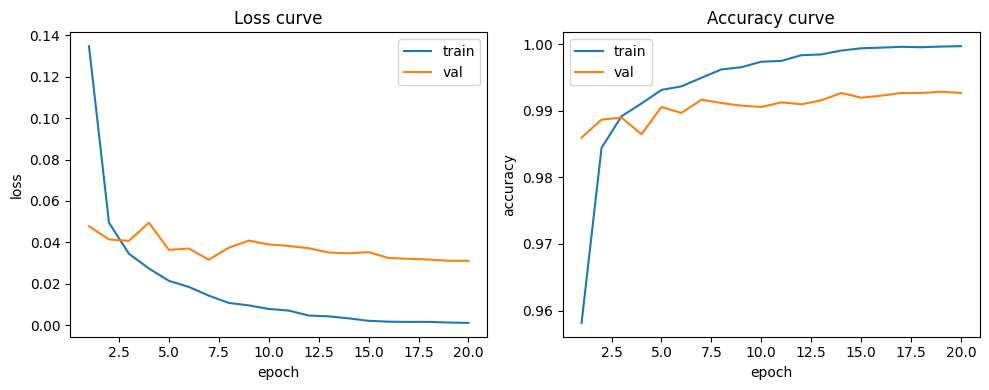

In [7]:
# 绘制训练/验证 loss、acc 曲线
epochs_axis = range(1, epochs + 1)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_axis, history["train_loss"], label="train")
plt.plot(epochs_axis, history["val_loss"], label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("Loss curve")

plt.subplot(1, 2, 2)
plt.plot(epochs_axis, history["train_acc"], label="train")
plt.plot(epochs_axis, history["val_acc"], label="val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.title("Accuracy curve")
plt.tight_layout()
plt.show()

#### 测试集评估与报告
加载最佳权重，输出分类报告。


In [8]:
# 在测试集上评估并输出分类报告
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

report = classification_report(all_labels, all_preds, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9939    0.9969    0.9954       980
           1     0.9938    0.9965    0.9952      1135
           2     0.9932    0.9932    0.9932      1032
           3     0.9941    0.9980    0.9960      1010
           4     0.9889    0.9939    0.9914       982
           5     0.9966    0.9944    0.9955       892
           6     0.9958    0.9916    0.9937       958
           7     0.9912    0.9912    0.9912      1028
           8     0.9949    0.9928    0.9938       974
           9     0.9940    0.9871    0.9906      1009

    accuracy                         0.9936     10000
   macro avg     0.9936    0.9936    0.9936     10000
weighted avg     0.9936    0.9936    0.9936     10000



#### 混淆矩阵可视化
展示类别混淆情况。


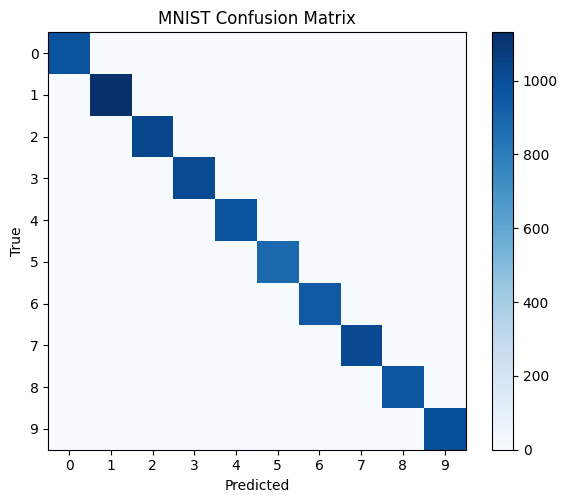

In [9]:
# 绘制混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap="Blues")
ax.figure.colorbar(im, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks(range(10))
ax.set_yticks(range(10))
ax.set_title("MNIST Confusion Matrix")
plt.tight_layout()
plt.show()

#### 学号图片预处理与分割策略（与 predict_id.py 一致）
OpenCV 流程：灰度+高斯模糊→Otsu 二值/反色→形态学闭操作→Canny 行列投影粗定位→轮廓外接矩形分割，若轮廓不足则列投影切分连体→裁空白、方形填充、缩放到 28×28 → MNIST 均值方差归一化。可通过 invert/min_area/pad/min_width 参数微调。


In [ ]:
# 学号图片分割预处理（与 predict_id.py 一致）
def segment_id_image(path, invert=True, min_area=60, pad=6, min_width=8):
    """
    OpenCV 分割流程：灰度+高斯模糊→Otsu 二值/反色→形态学闭操作→Canny 行列投影粗裁剪→轮廓外接矩形分割；
    若轮廓不足则列投影切分连体。每段裁空白、方形填充、缩放到 28×28，并按 MNIST 均值方差归一化。
    参数可调：invert、min_area、pad、min_width。
    """
    # 读取图像
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"File not found: {path}")

    # 预处理：去噪
    blur = cv2.GaussianBlur(img, (5, 5), 0)

    # 预处理：反转
    thresh_mode = cv2.THRESH_BINARY_INV if invert else cv2.THRESH_BINARY
    # 使用 Otsu 算法自动寻找最佳的二值化阈值
    _, binary = cv2.threshold(blur, 0, 255, thresh_mode + cv2.THRESH_OTSU)

    # 预处理：闭操作
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)

    # 粗定位：去除背景边缘
    # 使用 Canny 检测边缘，用于确定文字的大致区域
    edges = cv2.Canny(blur, 100, 200)
    # 行列投影：分别计算每一行和每一列的白色像素点数量
    rows_on = np.where(edges.sum(axis=1) > 0)[0] 
    cols_on = np.where(edges.sum(axis=0) > 0)[0] 
    
    # 如果检测到了内容，进行裁剪（ROI Crop）
    if rows_on.size and cols_on.size:
        y0, y1 = rows_on[[0, -1]] 
        x0, x1 = cols_on[[0, -1]] 
        # 裁剪时保留 5 像素的缓冲（padding），防止切掉笔画边缘
        binary = binary[max(0, y0 - 5):min(img.shape[0], y1 + 5), max(0, x0 - 5):min(img.shape[1], x1 + 5)]

    # 轮廓检测
    # 寻找最外层轮廓
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
    boxes = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c) # 获取包围盒
        # 过滤噪点：剔除面积过小或高度过矮（可能是横线或污渍）的轮廓
        if w * h < min_area or h < 8:
            continue
        boxes.append((x, y, w, h))

    boxes = sorted(boxes, key=lambda b: b[0])

    # 投影切分
    # 仅在轮廓检测失败（如 boxes 为空）时使用，通过垂直投影切分字符
    def split_by_projection(mask):
        col = (mask.sum(axis=0) > 0).astype(np.uint8) # 每一列是否有像素
        segs, s = [], None
        for i, v in enumerate(col):
            if v and s is None: # 进入字符区域
                s = i
            if not v and s is not None: # 离开字符区域
                if i - s >= min_width: # 过滤过窄的噪声
                    segs.append((s, i))
                s = None
        # 处理最后一个字符直到图像边缘的情况
        if s is not None and len(col) - s >= min_width:
            segs.append((s, len(col)))
        return segs


    norm = transforms.Normalize((0.1307,), (0.3081,))
    processed = []

    # 决策：优先使用轮廓框，如果没有则使用投影切分
    if boxes:
        segments = [(x, y, x + w, y + h) for x, y, w, h in boxes]
    else:
        segments = [(l, 0, r, binary.shape[0]) for l, r in split_by_projection(binary)]

    # 单个字符处理循环
    for x0, y0, x1, y1 in segments:
        # 在切出的字符周围增加 pad，避免紧贴边界
        x0 = max(0, x0 - pad)
        y0 = max(0, y0 - pad)
        x1 = min(binary.shape[1], x1 + pad)
        y1 = min(binary.shape[0], y1 + pad)
        digit = binary[y0:y1, x0:x1]

        if digit.sum() == 0: # 跳过纯黑块
            continue

        # 二次精修裁剪：去除字符单独切片后的多余黑边
        rows = digit.sum(axis=1) > 0
        cols = digit.sum(axis=0) > 0
        digit = digit[rows][:, cols]

        # 10. 调整尺寸与填充（保持长宽比）
        h, w = digit.shape
        side = max(h, w) + 8 # 创建一个正方形画布，边长为最大边+8
        canvas = np.zeros((side, side), dtype=np.uint8) # 黑色背景
        
        # 计算偏移量，将数字居中放置
        y_off = (side - h) // 2
        x_off = (side - w) // 2
        canvas[y_off:y_off + h, x_off:x_off + w] = digit

        # 转换为模型输入格式
        pil = Image.fromarray(canvas)
        # 强制缩放到 28x28 (MNIST 标准尺寸)
        pil = pil.resize((28, 28), Image.BILINEAR)
        # 转换为 PyTorch Tensor (数值范围 0~1)
        tensor = transforms.ToTensor()(pil)
        # 归一化 (数值范围变为标准正态分布附近)
        tensor = norm(tensor)
        
        processed.append((pil, tensor))
    
    return processed

print("Segmentation helper ready. Example usage: segment_id_image('my_id.jpg')")

Segmentation helper ready. Example usage: segment_id_image('my_id.jpg')


#### 学号预测与展示（与 predict_id.py 同步）
默认使用 `my_id.jpg`，可改路径；分割参数与脚本一致，可按需调整。


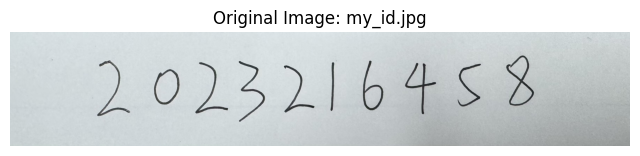

识别学号： 2023216458
分割位数： 10 


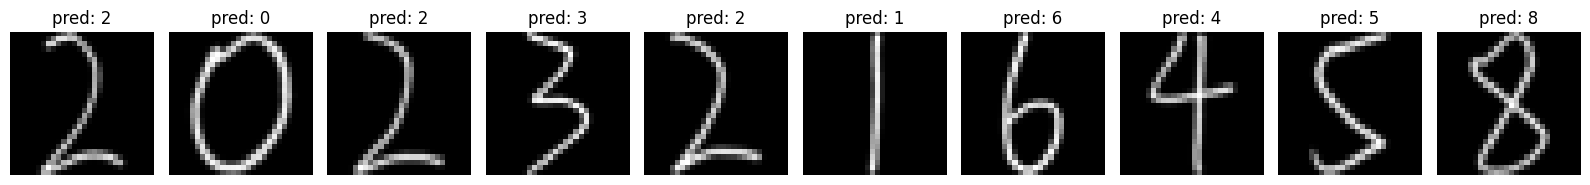

In [11]:
# 调用分割与模型推理学号，并可视化每位预测结果
def predict_digits(model, digits, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for _, tensor in digits:
            logit = model(tensor.unsqueeze(0).to(device))
            preds.append(str(logit.argmax(dim=1).item()))
    return ''.join(preds)

id_path = 'my_id.jpg' 
original_img = Image.open(id_path)
plt.figure(figsize=(8, 4))
plt.imshow(original_img)
plt.title(f'Original Image: {id_path}')
plt.axis('off')
plt.show() # 显示原图
digits = segment_id_image(id_path, invert=True, min_area=60, pad=6, min_width=8)
if not digits:
    print('未检测到数字，尝试调整 --invert/--min-area/--pad/--min-width。')
else:
    id_number = predict_digits(model, digits, device)
    print(f'识别学号： {id_number}')
    print(f'分割位数： {len(digits)} ')

    cols = len(digits)
    fig, axes = plt.subplots(1, cols, figsize=(1.6 * cols, 2))
    if cols == 1:
        axes = [axes]
    for ax, (pil_img, digit_char) in zip(axes, zip([p[0] for p in digits], id_number)):
        ax.imshow(pil_img, cmap='gray')
        ax.set_title(f'pred: {digit_char}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
